In [12]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# ------------------------------
# Load and Preprocess Data
# ------------------------------
data_file = '/Users/devshah/Documents/WorkSpace/University/year 3/CSC392/Trading_Simulator/data/data.csv'
df = pd.read_csv(data_file, parse_dates=True, index_col=0)

# Define features and target
feature_columns = [col for col in df.columns if col != 'target']
X = df[feature_columns].values
y = df['target'].values

# Optionally scale the features (LightGBM doesn't require scaling but sometimes it helps)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 80/20 train-test split (using index split as before)
split_index = int(0.75 * len(X_scaled))
X_train = X_scaled[:split_index]
X_test = X_scaled[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# ------------------------------
# Train LightGBM Model
# ------------------------------
# Using the scikit-learn API for LightGBM
model = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,            # no limit on tree depth
    learning_rate=0.005,
    n_estimators=1000,       # large number, but will use early stopping
    objective='binary'
)

# Train with early stopping on the test set (using AUC as evaluation metric)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc')
#     callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=50)]
# )


# ------------------------------
# Evaluation
# ------------------------------
# Get predicted probabilities and convert to binary predictions
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

print("\nTest Accuracy: {:.2f}".format(acc))
print("Test AUC: {:.2f}".format(auc))
print("Confusion Matrix:\n", cm)

# ------------------------------
# Analysis (if 'close' column exists)
# ------------------------------
if 'close' in df.columns:
    # Copy test portion of the data for analysis
    analysis_df = df.iloc[split_index:].copy()
    
    # Add predictions as trading directions
    analysis_df['predicted_direction'] = y_pred
    
    # Calculate next day return using the close price
    analysis_df['next_day_return'] = analysis_df['close'].pct_change().shift(-1)
    
    # Calculate strategy returns based on predicted direction
    analysis_df['strategy_return'] = analysis_df['next_day_return'] * analysis_df['predicted_direction']
    
    # Calculate cumulative returns for both strategy and market
    analysis_df['cumulative_strategy_return'] = (1 + analysis_df['strategy_return']).cumprod()
    analysis_df['cumulative_market_return'] = (1 + analysis_df['next_day_return']).cumprod()
    
    # Get final returns (excluding potential NaN at the end)
    strategy_return = analysis_df['cumulative_strategy_return'].iloc[-2] - 1
    market_return = analysis_df['cumulative_market_return'].iloc[-2] - 1
    
    print("\nStrategy Return: {:.2%}".format(strategy_return))
    print("Market Return: {:.2%}".format(market_return))


[LightGBM] [Info] Number of positive: 2456, number of negative: 2296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 4752, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516835 -> initscore=0.067366
[LightGBM] [Info] Start training from score 0.067366

Test Accuracy: 0.53
Test AUC: 0.52
Confusion Matrix:
 [[295 444]
 [306 540]]

Strategy Return: 110.68%
Market Return: 5.37%


[LightGBM] [Info] Number of positive: 2456, number of negative: 2296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 4752, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516835 -> initscore=0.067366
[LightGBM] [Info] Start training from score 0.067366

Test Accuracy: 0.53
Test AUC: 0.52

Confusion Matrix:
 [[295 444]
 [306 540]]

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.40      0.44       739
           1       0.55      0.64      0.59       846

    accuracy                           0.53      1585
   macro avg       0.52      0.52      0.52      1585
weighted avg       0.52      0.53      0.52      1585



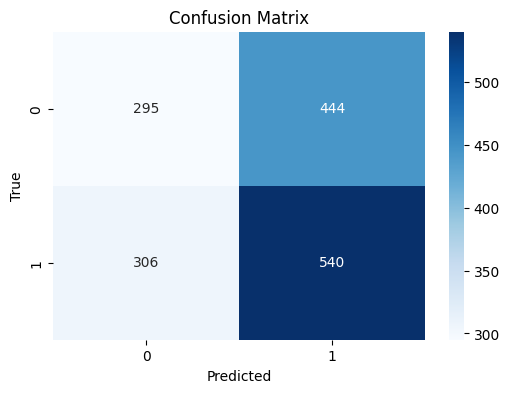

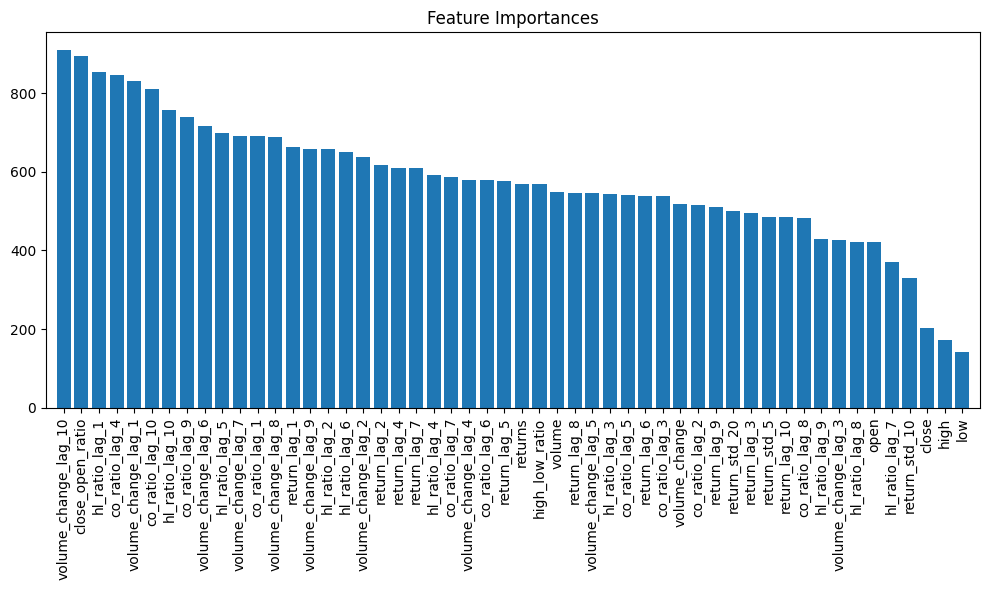


Strategy Return: 110.68%
Market Return: 5.37%


In [15]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Load and Preprocess Data
# ------------------------------
data_file = '/Users/devshah/Documents/WorkSpace/University/year 3/CSC392/Trading_Simulator/data/data.csv'
df = pd.read_csv(data_file, parse_dates=True, index_col=0)

# Define features and target
feature_columns = [col for col in df.columns if col != 'target']
X = df[feature_columns].values
y = df['target'].values

# Optionally scale features (LightGBM can handle raw data, but scaling may sometimes help)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use a 75/25 train-test split (preserving time order)
split_index = int(0.75 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# ------------------------------
# Train LightGBM Model
# ------------------------------
model = lgb.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,            # no limit on tree depth
    learning_rate=0.005,
    n_estimators=1000,       # large number; early stopping will determine the optimal iteration
    objective='binary',
    random_state=42          # for reproducibility
)

# Train with early stopping (using AUC as the evaluation metric)
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
)

# ------------------------------
# Evaluation
# ------------------------------
# Get predicted probabilities and binary predictions
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute evaluation metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

print("\nTest Accuracy: {:.2f}".format(acc))
print("Test AUC: {:.2f}".format(auc))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_columns)[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

# ------------------------------
# Analysis (if 'close' column exists)
# ------------------------------
if 'close' in df.columns:
    # Use the test portion of the data for further analysis
    analysis_df = df.iloc[split_index:].copy()
    
    # Add the model's predictions as trading directions
    analysis_df['predicted_direction'] = y_pred
    
    # Calculate next-day returns using the close price
    analysis_df['next_day_return'] = analysis_df['close'].pct_change().shift(-1)
    
    # Calculate strategy returns (assuming long position when prediction == 1)
    analysis_df['strategy_return'] = analysis_df['next_day_return'] * analysis_df['predicted_direction']
    
    # Compute cumulative returns for both the strategy and the market
    analysis_df['cumulative_strategy_return'] = (1 + analysis_df['strategy_return']).cumprod()
    analysis_df['cumulative_market_return'] = (1 + analysis_df['next_day_return']).cumprod()
    
    # Exclude the last row if it contains NaN values before computing final returns
    strategy_return = analysis_df['cumulative_strategy_return'].iloc[-2] - 1
    market_return = analysis_df['cumulative_market_return'].iloc[-2] - 1
    
    print("\nStrategy Return: {:.2%}".format(strategy_return))
    print("Market Return: {:.2%}".format(market_return))
